<a href="https://colab.research.google.com/github/KaipoCraft/mapGAN/blob/main/low_res_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MapGAN
**_Melanie Sharif and Neill Shikada_**

**_Professor: Robin Burke_**

**INFO5604 Applied Machine Learning**

## About the Model
This file shows a simple GAN. This GAN is built using two convolutional neural networks. The first model is the generator and is designed to generate random images that are fed into the second model, the discriminator. The discriminator tries to distinguish between the real images fed from the dataset and the fake ones generated by the generator.
## References
Here are a few references we used in our 

Resources
Style GAN opensource repo
https://github.com/NVlabs/stylegan2-ada-pytorch
How to build a GAN
https://www.youtube.com/watch?v=AALBGpLbj6Q&t=813s&ab_channel=NicholasRenotte
Intro to geemap and Google Earth Engine
https://www.youtube.com/watch?v=wGjpjh9IQ5I&list=PLAxJ4-o7ZoPccOFv1dCwvGI6TYnirRTg3&ab_channel=QiushengWu

Google Earth Engine Python Documentation
https://developers.google.com/earth-engine/guides/python_install
Google Earth Engine sample workflow
https://github.com/google/earthengine-api/blob/master/python/examples/ipynb/Earth_Engine_TensorFlow_AI_Platform.ipynb

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Import Dependencies

Basic ML packages

In [2]:
import scipy as sp
import pandas as pd
import numpy as np

Visualization packages

In [3]:
import matplotlib.pyplot as plt
import seaborn as sb


Tensorflow

In [4]:
import tensorflow as tf

In [5]:
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD

other

In [6]:
from PIL import Image
from tqdm import tqdm
import os 
import time

# 2. Data

In [7]:
from google.colab import drive
drive.mount('/content/drive')

GENERATE_RES = 2 # Generation resolution factor 
# (1=32, 2=64, 3=96, 4=128, etc.)
GENERATE_SQUARE = 32 * GENERATE_RES # rows/cols (should be square)
IMAGE_CHANNELS = 3

# Preview image
PREVIEW_ROWS = 2
PREVIEW_COLS = 2
PREVIEW_MARGIN = 16

# Size vector to generate images from
SEED_SIZE = 100

# Configuration
DATA_PATH = '/content/drive/MyDrive/mapGAN4'
EPOCHS = 100
BATCH_SIZE = 16
BUFFER_SIZE = 60000

print(f"Will generate {GENERATE_SQUARE}px square images.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Will generate 64px square images.


In [9]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

training_binary_path = os.path.join(DATA_PATH,
        f'training_data_{GENERATE_SQUARE}_{GENERATE_SQUARE}.npy')

print(f"Looking for file: {training_binary_path}")

if not os.path.isfile(training_binary_path):
  start = time.time()
  print("Loading training images...")

  training_data = []
  faces_path = os.path.join(DATA_PATH)
  for filename in tqdm(os.listdir(faces_path)):
      path = os.path.join(faces_path,filename)
      image = Image.open(path).resize((GENERATE_SQUARE,
            GENERATE_SQUARE),Image.ANTIALIAS)
      training_data.append(np.asarray(image))
  training_data = np.reshape(training_data,(-1,GENERATE_SQUARE,
            GENERATE_SQUARE,IMAGE_CHANNELS))
  training_data = training_data.astype(np.float32)
  training_data = training_data / 127.5 - 1.


  print("Saving training image binary...")
  np.save(training_binary_path,training_data)
  elapsed = time.time()-start
  print (f'Image preprocess time: {hms_string(elapsed)}')
else:
  print("Loading previous training pickle...")
  training_data = np.load(training_binary_path)

#shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(training_data) \
    .shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

Looking for file: /content/drive/MyDrive/mapGAN4/training_data_64_64.npy
Loading training images...


  0%|          | 0/39 [00:00<?, ?it/s]


UnidentifiedImageError: ignored

In [ ]:
def save_images(cnt,noise):
  image_array = np.full(( 
      PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 
      PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN)), 3), 
      255, dtype=np.uint8)
  
  generated_images = generator.predict(noise)

  generated_images = 0.5 * generated_images + 0.5

  image_count = 0
  for row in range(PREVIEW_ROWS):
      for col in range(PREVIEW_COLS):
        r = row * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        c = col * (GENERATE_SQUARE+16) + PREVIEW_MARGIN
        image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] \
            = generated_images[image_count] * 255
        image_count += 1

          
  output_path = os.path.join(DATA_PATH,'output')
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  filename = os.path.join(output_path,f"train-{cnt}.png")
  im = Image.fromarray(image_array)
  im.save(filename)

# 3. Build Neural Networks

## 3.2 Build Generator

In [ ]:
#building the generator
def build_generator(seed_size, channels):
    model = Sequential()

    model.add(Dense(4*4*256,activation="relu",input_dim=seed_size))
    model.add(Reshape((4,4,256)))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    model.add(UpSampling2D())
    model.add(Conv2D(256,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
   
    # Output resolution, additional upsampling
    model.add(UpSampling2D())
    model.add(Conv2D(128,kernel_size=3,padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))

    if GENERATE_RES>1:
      model.add(UpSampling2D(size=(GENERATE_RES,GENERATE_RES)))
      model.add(Conv2D(128,kernel_size=3,padding="same"))
      model.add(BatchNormalization(momentum=0.8))
      model.add(Activation("relu"))

    # Final CNN layer
    model.add(Conv2D(channels,kernel_size=3,padding="same"))
    model.add(Activation("tanh"))

    return model

## 3.3 Build Discriminator

In [ ]:
#building the discriminator
def build_discriminator(image_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=image_shape, 
                     padding="same"))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Conv2D(512, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

# 4. Training

tf.Tensor([[0.5007379]], shape=(1, 1), dtype=float32)


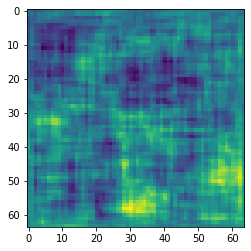

In [ ]:
generator = build_generator(SEED_SIZE, IMAGE_CHANNELS)

noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0])

image_shape = (GENERATE_SQUARE,GENERATE_SQUARE,IMAGE_CHANNELS)

discriminator = build_discriminator(image_shape)
decision = discriminator(generated_image)
print(decision)

cross_entropy = tf.keras.losses.BinaryCrossentropy()

#discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

#generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
#generator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
discriminator_optimizer = tf.keras.optimizers.Adam(1.5e-4,0.5)
#discriminator_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [ ]:
#from https://www.tensorflow.org/tutorials/generative/dcgan
#using pre-compiling
@tf.function
def train_step(images):
  seed = tf.random.normal([BATCH_SIZE, SEED_SIZE])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(seed, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)
    

    gradients_of_generator = gen_tape.gradient(\
        gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(\
        disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(
        gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(
        gradients_of_discriminator, 
        discriminator.trainable_variables))
  return gen_loss,disc_loss

#training 
def train(dataset, epochs):
  fixed_seed = np.random.normal(0, 1, (PREVIEW_ROWS * PREVIEW_COLS, 
                                       SEED_SIZE))
  start = time.time()

  for epoch in range(epochs):
    epoch_start = time.time()

    gen_loss_list = []
    disc_loss_list = []

    for image_batch in dataset:
      t = train_step(image_batch)
      gen_loss_list.append(t[0])
      disc_loss_list.append(t[1])

    g_loss = sum(gen_loss_list) / len(gen_loss_list)
    d_loss = sum(disc_loss_list) / len(disc_loss_list)

    epoch_elapsed = time.time()-epoch_start
    print (f'Epoch {epoch+1}, gen loss={g_loss},disc loss={d_loss},'\
           ' {hms_string(epoch_elapsed)}')
    save_images(epoch,fixed_seed)

  elapsed = time.time()-start
  print (f'Training time: {hms_string(elapsed)}')

train(train_dataset, EPOCHS)

Epoch 1, gen loss=0.9690646529197693,disc loss=1.5506353378295898, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 125ms/step
Epoch 2, gen loss=1.2313545942306519,disc loss=1.3242579698562622, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 3, gen loss=0.9897303581237793,disc loss=1.3891716003417969, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 4, gen loss=1.120313286781311,disc loss=1.1489533185958862, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 5, gen loss=1.3530868291854858,disc loss=1.042638897895813, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 17ms/step
Epoch 6, gen loss=1.598588466644287,disc loss=0.9105803370475769, {hms_string(epoch_elapsed)}
1/1 [==============================] - 0s 18ms/step
Epoch 7, gen loss=1.4682759046554565,disc loss=0.8695600032806396, {hms_string(epoch_elapsed)}
1/1 [====================